In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from numpy.typing import NDArray
from envs.riverswim import RiverSwim
from envs.forked_riverswim import ForkedRiverSwim
from scipy.special import rel_entr
from new_mdp_description import MDPDescription2
from utils import policy_evaluation
import multiprocessing as mp
import torch
from scipy.stats import t
from parameters import Parameters
from typing import NamedTuple, Dict
import lzma
def TV(p,q):
    return np.sum(np.abs(p-q), -1) * 0.5

def CE(x, c=0.95):
    N = x.shape[0]
    alpha = c + (1-c)/2
    c = t.ppf(alpha, N)
    s = np.std(x, axis=0, ddof=1)
    return x.mean(0), c * s/ np.sqrt(N)


    
compute_dist_omega = lambda x,y: TV(x,y)
compute_dist_value = lambda V, mdp: np.linalg.norm(V -mdp.V_greedy[np.newaxis, np.newaxis], axis=-1)




/home/alessio/anaconda3/envs/rlexploration/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import matplotlib as mpl
TITLE_SIZE = 24
LEGEND_SIZE = 15
TICK_SIZE = 15
AXIS_TITLE = TITLE_SIZE-4
AXIS_LABEL = 18
FONT_SIZE = TITLE_SIZE-4


plt.rc('font', size=FONT_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=AXIS_TITLE)     # fontsize of the axes title
plt.rc('axes', labelsize=AXIS_LABEL)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=TICK_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=TICK_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LEGEND_SIZE)    # legend fontsize
plt.rc('figure', titlesize=TITLE_SIZE)  # fontsize of the figure title

# plt.rcParams.update({
#     "font.family": "serif",  # use serif/main font for text elements
#     "text.usetex": True,  # use inline math for ticks
#     "pgf.rcfonts": False,  # don't setup fonts from rc parameters
#     "pgf.preamble": [
#         "\\usepackage{units}",  # load additional packages
#         "\\usepackage{metalogo}",
#         "\\usepackage{unicode-math}",  # unicode math setup
#         r"\setmathfont{xits-math.otf}",
#         r'\usepackage{amsmath}',
#         r"\setmainfont{DejaVu Serif}",  # serif font via preamble
#         r'\usepackage{siunitx}',   # i need upright \micro symbols, but you need...
#         r'\sisetup{detect-all}',   # ...this to force siunitx to actually use your fonts
#         r'\usepackage{helvet}',    # set the normal font here
#         r'\usepackage{sansmath}',  # load up the sansmath so that math -> helvet
#         r'\sansmath'               # <- tricky! -- gotta actually tell tex to use!
#     ]
# })

In [4]:
def get_data(data, key: str, parameters: Parameters):
    data_ret = []
    num_visits = []
    policies = []
    last_visit = []
    visits = []
    val_greedy = []
    for i in range(parameters.n_sims):
        _data, _greedy_policy, _num_visits, _last_visit, _visits, _val_greedy  = zip(*data[f'agent_{key}'][i])
        data_ret.append(_data)
        num_visits.append(_num_visits)
        policies.append(_greedy_policy)
        last_visit.append(_last_visit)
        visits.append(_visits)
        val_greedy.append(_val_greedy)
    if isinstance(data_ret[0][0], torch.Tensor):
        data_ret = []
    
    return np.array(data_ret), np.array(policies), np.array(num_visits),  np.array(last_visit), np.array(visits), np.array(val_greedy)

def compute_value(policies, env, parameters: Parameters):
    value = np.zeros_like(policies)
    for i in range(policies.shape[0]):
        for t in range(policies.shape[1]):
            value[i,t] = policy_evaluation(parameters.gamma, env.transitions, env.rewards[..., np.newaxis], policies[i,t])
    return value



def eval_allocations(allocation, mdp, U, num_actions=2):
    eval_x = np.zeros((allocation.shape[0], allocation.shape[1]))
    for i in range(allocation.shape[0]):
        for j in range(allocation.shape[1]):
            eval_x[i,j] = mdp.evaluate_allocation(allocation[i,j].reshape(-1, num_actions))
            if np.isinf(eval_x[i,j]):
                eps = 1e-3
                U = np.ones_like(allocation[i,j].reshape(-1, num_actions)) / np.prod(allocation[i,j].shape)
                omega = (1-eps) * allocation[i,j].reshape(-1, num_actions) + eps * U
                eval_x[i,j] = mdp.evaluate_allocation(omega)
    return eval_x

class Results(NamedTuple):
    omega: NDArray[np.float64]
    greedy: NDArray[np.float64]
    freq_visits: NDArray[np.float64]
    last_visits: NDArray[np.float64]
    visits: NDArray[np.float64]
    val_greedy: NDArray[np.float64]
    idxs: NDArray[np.bool_]
    dist_omega: NDArray[np.float64]
    U_omega: NDArray[np.float64]
    dist_value: NDArray[np.float64]

In [5]:

fname_riverswim = './data/data_riverswim_20.pkl'
with lzma.open(fname_riverswim, 'rb') as f:
    data_riverswim = pickle.load(f)

parameters: Parameters = data_riverswim['parameters']
env = RiverSwim(parameters.river_length, parameters.min_reward, parameters.max_reward_1)
true_mdp = MDPDescription2(env.transitions, env.rewards[..., np.newaxis], parameters.gamma, 1)
true_omega, _ = true_mdp.compute_allocation(navigation_constraints=True)

KeyboardInterrupt: 

In [9]:
U = true_mdp.evaluate_allocation(true_omega)



results: Dict[str, Results] = {}
for agent in ['MFBPI', 'MFBPI-GEN', 'MBBPI', 'QLEARNING', 'QUCB', 'MBBPIBayes', 'MFBPIProjected', 'MFBPIUCB']:
    omega, greedy, freq_visits, last_visit, visits, val_greedy = get_data(data_riverswim, agent, parameters)
    
    idxs = np.argwhere(np.array(range(parameters.horizon)) % parameters.frequency_computation == 0).flatten()
    omega = omega[:, idxs, ...].reshape(parameters.n_sims, len(idxs), -1)

    dist_omega = compute_dist_omega(omega, true_omega.flatten()[np.newaxis, np.newaxis, ...])
    U_omega = eval_allocations(omega, true_mdp, U)
    dist_value = compute_dist_value(val_greedy, true_mdp)[:, idxs]
    results[agent] = Results(omega, greedy, freq_visits, last_visit, visits, val_greedy, idxs, dist_omega, U_omega, dist_value)

: 

: 

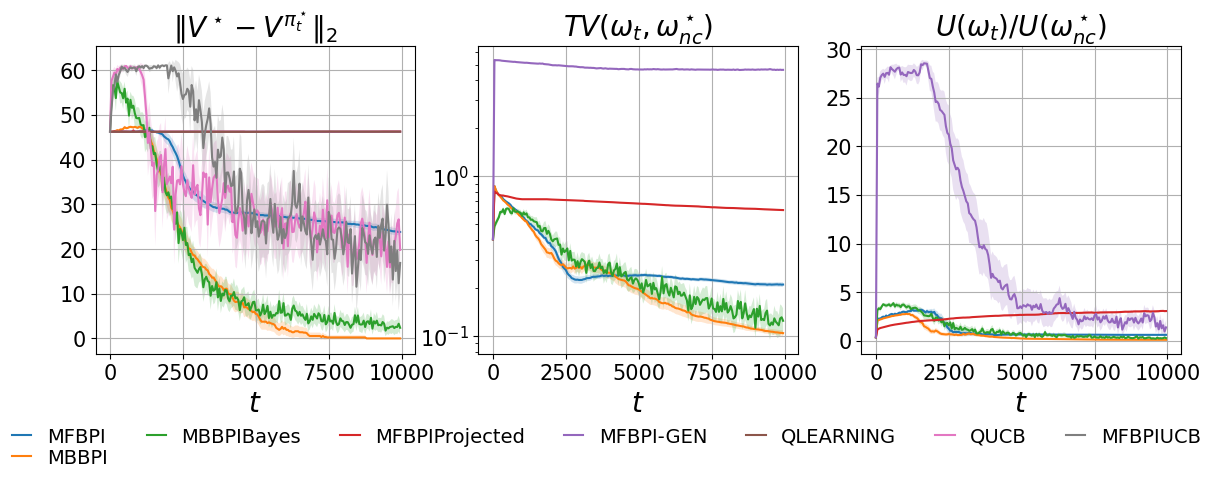

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(14,4))

x = range(0, parameters.horizon, parameters.frequency_computation)



for agent in ['MFBPI', 'MBBPI', 'MBBPIBayes', 'MFBPIProjected','MFBPI-GEN',  'QLEARNING', 'QUCB', 'MFBPIUCB']:
    mu, ce = CE(results[agent].dist_value)
    ax[0].plot(x, mu, label=agent)
    ax[0].fill_between(x, mu-ce, mu+ce, alpha=0.2)
    ax[0].set_title('$\|V^\star - V^{\pi_t^\star}\|_2$')

for agent in ['MFBPI', 'MBBPI', 'MBBPIBayes', 'MFBPIProjected','MFBPIUCB']:    
    mu, ce = CE(results[agent].dist_omega)
    ax[1].plot(x, mu, label=agent)
    ax[1].fill_between(x, mu-ce, mu+ce, alpha=0.2)
    ax[1].set_title(r'$TV(\omega_t,\omega_{nc}^\star)$')

ax[1].set_yscale('log')


for agent in ['MFBPI', 'MBBPI', 'MBBPIBayes', 'MFBPIProjected','MFBPIUCB']:
    mu, ce = CE(np.log10(results[agent].U_omega  / U))
    ax[2].plot(x, mu, label=agent)
    ax[2].fill_between(x, mu-ce, mu+ce, alpha=0.2)
    ax[2].set_title(r'$U(\omega_t)/U(\omega_{nc}^\star)$')
#ax[2].set_yscale("log")

for i in range(3):
    ax[i].set_xlabel('$t$')
    ax[i].grid()

ax[0].legend(ncols=7, bbox_to_anchor=(3.5, -0.2), frameon=False,fontsize=14, borderpad=0.1, labelspacing=0.1, handlelength=1)
plt.show()

In [15]:
data_riverswim.keys()

dict_keys(['parameters', 'agents', 'agent_MFBPI', 'agent_MFBPI-GEN', 'agent_MBBPI', 'agent_QLEARNING', 'agent_QUCB', 'agent_MBBPIBayes', 'agent_MFBPIProjected'])

In [11]:

fname_forked_riverswim = './data/data_forked_riverswim_10.pkl'
with lzma.open(fname_forked_riverswim, 'rb') as f:
    data_forked_riverswim = pickle.load(f)
parameters: Parameters = data_forked_riverswim['parameters']
env = ForkedRiverSwim(parameters.river_length, parameters.min_reward, parameters.max_reward_1, parameters.max_reward_2)
true_mdp = MDPDescription2(env.transitions, env.rewards[..., np.newaxis], parameters.gamma, 1)
true_omega, _ = true_mdp.compute_allocation(navigation_constraints=True)

: 

: 

In [ ]:
U = true_mdp.evaluate_allocation(true_omega)


results: Dict[str, Results] = {}
for agent in ['MFBPI', 'MFBPI-GEN', 'MBBPI', 'QLEARNING', 'QUCB', 'MBBPIBayes', 'MFBPIProjected', 'MFBPIUCB']:
    omega, greedy, freq_visits, last_visit, visits, val_greedy = get_data(data_forked_riverswim, agent, parameters)
    
    idxs = np.argwhere(np.array(range(parameters.horizon)) % parameters.frequency_computation == 0).flatten()
    omega = omega[:, idxs, ...].reshape(parameters.n_sims, len(idxs), -1)

    dist_omega = compute_dist_omega(omega, true_omega.flatten()[np.newaxis, np.newaxis, ...])
    U_omega = eval_allocations(omega, true_mdp, U, 3)
    dist_value = compute_dist_value(val_greedy, true_mdp)[:, idxs]
    results[agent] = Results(omega, greedy, freq_visits, last_visit, visits, val_greedy, idxs, dist_omega, U_omega, dist_value)

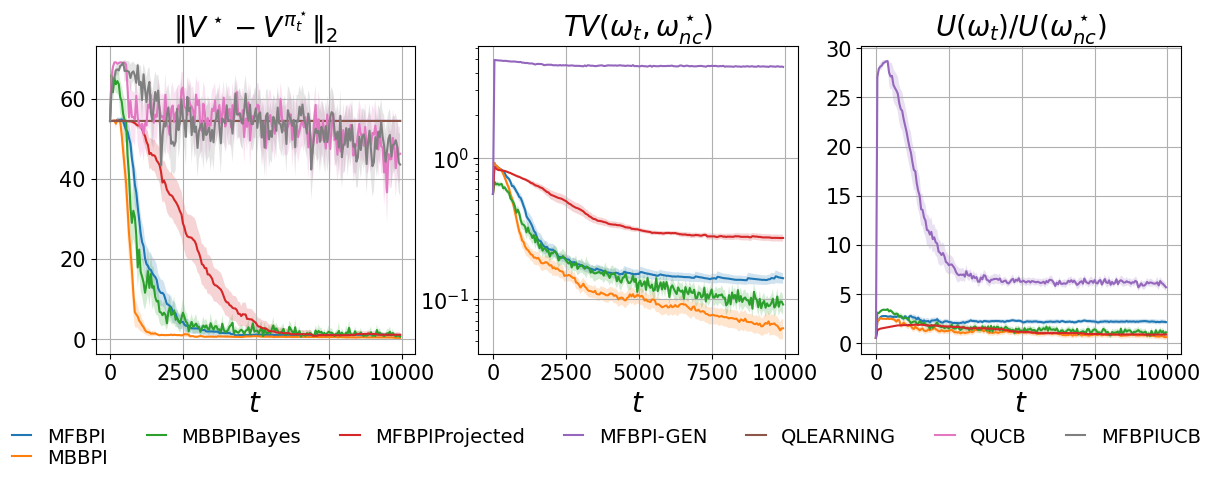

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(14,4))

x = range(0, parameters.horizon, parameters.frequency_computation)



for agent in ['MFBPI', 'MBBPI', 'MBBPIBayes', 'MFBPIProjected','MFBPI-GEN',  'QLEARNING', 'QUCB', 'MFBPIUCB']:
    mu, ce = CE(results[agent].dist_value)
    ax[0].plot(x, mu, label=agent)
    ax[0].fill_between(x, mu-ce, mu+ce, alpha=0.2)
    ax[0].set_title('$\|V^\star - V^{\pi_t^\star}\|_2$')

for agent in ['MFBPI', 'MBBPI', 'MBBPIBayes', 'MFBPIProjected', 'MFBPIUCB']:    
    mu, ce = CE(results[agent].dist_omega)
    ax[1].plot(x, mu, label=agent)
    ax[1].fill_between(x, mu-ce, mu+ce, alpha=0.2)
    ax[1].set_title(r'$TV(\omega_t,\omega_{nc}^\star)$')

ax[1].set_yscale('log')


for agent in ['MFBPI', 'MBBPI', 'MBBPIBayes', 'MFBPIProjected', 'MFBPIUCB']:
    mu, ce = CE(np.log10(results[agent].U_omega  / U))
    ax[2].plot(x, mu, label=agent)
    ax[2].fill_between(x, mu-ce, mu+ce, alpha=0.2)
    ax[2].set_title(r'$U(\omega_t)/U(\omega_{nc}^\star)$')
#ax[2].set_yscale("log")

for i in range(3):
    ax[i].set_xlabel('$t$')
    ax[i].grid()

ax[0].legend(ncols=7, bbox_to_anchor=(3.5, -0.2), frameon=False,fontsize=14, borderpad=0.1, labelspacing=0.1, handlelength=1)
plt.show()